<a href="https://colab.research.google.com/github/srikanth-gedela/SriMLModels/blob/main/DimensionalityReductionPCAvsAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#add necessary libraries
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np

import os

# Import required libraries
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.utils.data

from mpl_toolkits import mplot3d

%matplotlib inline

In [3]:
np.random.seed(112)

In [4]:
class autoencoder(nn.Module):
    def __init__(self,inputD,encoding_dim):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential()
        
        self.encoder.add_module("enc_0", nn.Linear(inputD,encoding_dim[0]))
        self.encoder.add_module("relu_0", nn.ReLU())
          
        for l in range(1,len(encoding_dim)):
            self.encoder.add_module("enc_"+str(l), nn.Linear(encoding_dim[l-1],encoding_dim[l]))
            self.encoder.add_module("encBn_"+str(l),nn.BatchNorm1d(encoding_dim[l]))
            self.encoder.add_module("encrelu_"+str(l), nn.ReLU())
                                    
        self.decoder = nn.Sequential()
        
        for l in range(len(encoding_dim)-1,0,-1):
            self.decoder.add_module("dec_"+str(l), nn.Linear(encoding_dim[l],encoding_dim[l-1]))
            self.decoder.add_module("decBn_"+str(l),nn.BatchNorm1d(encoding_dim[l-1]))
            self.decoder.add_module("decrelu_"+str(l), nn.ReLU())
            
        self.decoder.add_module("dec_0", nn.Linear(encoding_dim[0],inputD))
        self.decoder.add_module("decrelu_0", nn.Sigmoid())
        
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def representation(self, x):
        x = self.encoder(x)
        return x

In [5]:
def testAutoEncoderFit(matrix, encoding_dim,three_D=False,scatter=False):
    matrixtensor = torch.tensor(matrix).float()
    
    input_dim = matrix.shape[1]
    model = autoencoder(input_dim,encoding_dim).cuda()
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    
    data_tensor = torch.utils.data.TensorDataset(matrixtensor, matrixtensor) 
    dataloader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size = batch_size, shuffle = True)
    
    for epoch in range(num_epochs):
        for data in dataloader:
            X, _ = data
            X = X.cuda()
            # ===================forward=====================
            output = model(X)
            loss = criterion(output, X)
            MSE_loss = nn.MSELoss()(output, X)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
#         print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
#             .format(epoch + 1, num_epochs, loss.item(), MSE_loss.item()))   
    
    with torch.no_grad():
        reconMatrixAE = model(matrixtensor.cuda()).cpu().numpy()
    reconCostAE = np.mean(np.power(reconMatrixAE - matrix,2),axis = 1)
    reconCostAE = reconCostAE.reshape(-1, 1)
    
    
    if three_D:
        if scatter:
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            #ax.plot_wireframe(matrix[:,0],matrix[:,1],matrix[:,2])
            ax.scatter3D(reconMatrixAE[:,0],reconMatrixAE[:,1],reconMatrixAE[:,2])
            
        else:
            X = reconMatrixAE[:,0].reshape(samples,samples)
            Y = reconMatrixAE[:,1].reshape(samples,samples)
            Z = reconMatrixAE[:,2].reshape(samples,samples)

            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_wireframe(X,Y,Z)
    else:
        plt.plot(reconMatrixAE[:,0],reconMatrixAE[:,1])
    
    
    print('Reconstruction MSE : ',np.mean(reconCostAE))
    return np.mean(reconCostAE)

In [6]:
def testPCAFit(matrix,n,three_D=False,scatter=False):
    pca = PCA(n_components=n)
    pca.fit(matrix)

    reducedMatrixPCA = pca.transform(matrix)

    reconMatrixPCA = pca.inverse_transform(reducedMatrixPCA)
    reconCostPCA = np.mean(np.power(reconMatrixPCA - matrix,2),axis = 1)
    reconCostPCA = reconCostPCA.reshape(-1, 1)
    print('Reconstruction MSE : ',np.mean(reconCostPCA))
    
    if three_D:
        if scatter:
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            #ax.plot_wireframe(matrix[:,0],matrix[:,1],matrix[:,2])
            ax.scatter3D(reconMatrixPCA[:,0],reconMatrixPCA[:,1],reconMatrixPCA[:,2])
        else:
            X = reconMatrixPCA[:,0].reshape(samples,samples)
            Y = reconMatrixPCA[:,1].reshape(samples,samples)
            Z = reconMatrixPCA[:,2].reshape(samples,samples)

            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_wireframe(X,Y,Z)
    else:
        plt.plot(reconMatrixPCA[:,0],reconMatrixPCA[:,1])
    
    return np.mean(reconCostPCA)

### Linear Case

In [7]:
encoding_dim = [100,50,1]
learning_rate=0.0001
batch_size = 100
num_epochs = 1000

In [8]:
samples = 1000
matrix = np.empty((samples,2))
matrix[:,0] = np.linspace(0,1000,samples)
matrix[:,1] = 2*matrix[:,0] + 20
#matrix = matrix + 10 * np.random.normal(size=matrix.shape)
input_dim = matrix.shape[1]
matrix.shape

(1000, 2)

In [9]:
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

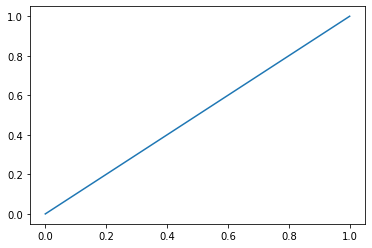

In [10]:
plt.plot(matrix[:,0],matrix[:,1])

Reconstruction MSE :  0.00023713597418328122


0.00023713597418328122

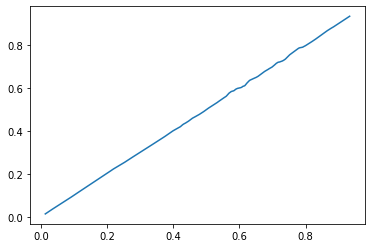

In [11]:
testAutoEncoderFit(matrix,encoding_dim)

Reconstruction MSE :  3.795687997844722e-33


3.795687997844722e-33

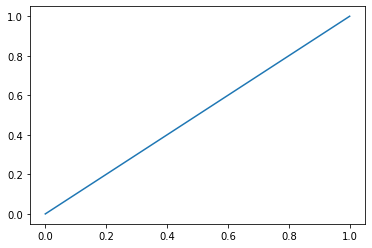

In [12]:
testPCAFit(matrix,1)

## Non Linear Case

In [35]:
samples = 1000
matrix = np.empty((samples,2))
matrix[:,0] = np.linspace(0,1000,samples)
matrix[:,1] = matrix[:,0]**2 + 20
#matrix = matrix + 10 * np.random.normal(size=matrix.shape)
matrix.shape

(1000, 2)

In [36]:
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

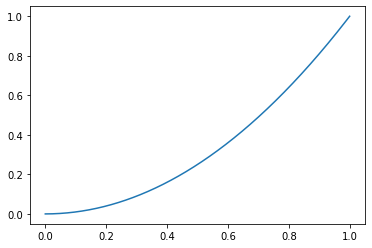

In [37]:
plt.plot(matrix[:,0],matrix[:,1])

Reconstruction MSE :  0.0021926138949180467


0.0021926138949180467

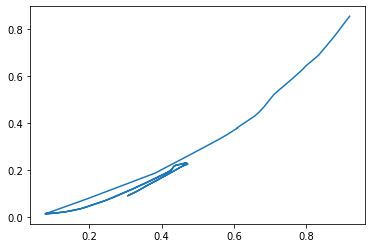

In [16]:
testAutoEncoderFit(matrix,encoding_dim)

Reconstruction MSE :  0.0013711705649795734


0.0013711705649795734

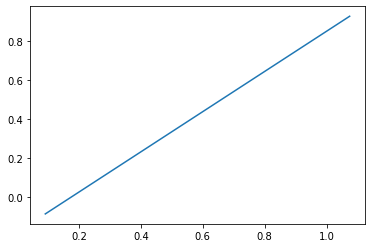

In [17]:
testPCAFit(matrix,1)

### More curvature

In [18]:
samples = 1000
matrix = np.empty((samples,2))
matrix[:,0] = np.linspace(0,1000,samples)
matrix[:,1] = matrix[:,0]**6 + 20
#matrix = matrix + 10 * np.random.normal(size=matrix.shape)
matrix.shape

(1000, 2)

In [19]:
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

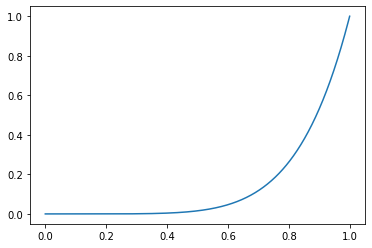

In [20]:
plt.plot(matrix[:,0],matrix[:,1])

Reconstruction MSE :  0.0025496657637715326


0.0025496657637715326

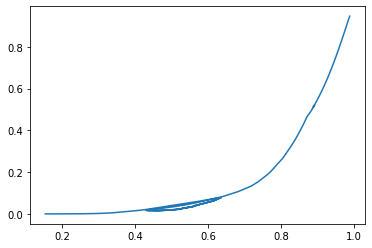

In [21]:
testAutoEncoderFit(matrix,encoding_dim)

Reconstruction MSE :  0.007386045092825467


0.007386045092825467

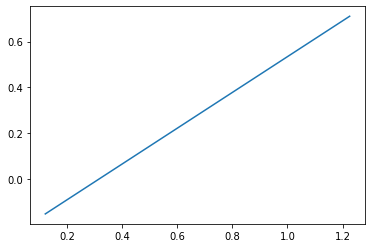

In [22]:
testPCAFit(matrix,1)

### Plane Example

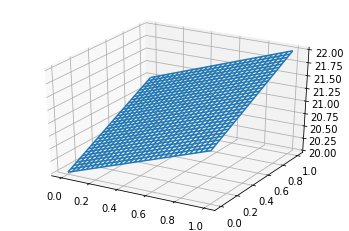

In [23]:
samples = 30
x = np.linspace(0,1,samples)
y = x
X,Y = np.meshgrid(x,y)
Z = Y + X+ 20

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X,Y,Z)
#ax.scatter3D(X, Y, Z)

In [24]:
matrix = np.empty((samples*samples,3))
matrix[:,0] = X.reshape(samples*samples)
matrix[:,1] = Y.reshape(samples*samples)
matrix[:,2] = Z.reshape(samples*samples)
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

Reconstruction MSE :  6.22038280052963e-32


6.22038280052963e-32

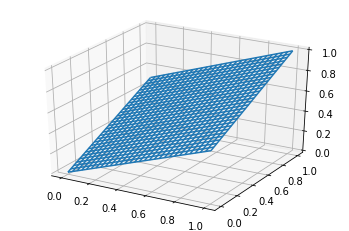

In [25]:
testPCAFit(matrix,2,True)

Reconstruction MSE :  0.0018351523226892955


0.0018351523226892955

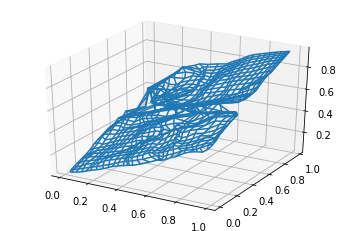

In [26]:
encoding_dim = [100,30,2]
learning_rate=0.0001
batch_size = 100
num_epochs = 1000
testAutoEncoderFit(matrix,encoding_dim,True)

### Curved Surface

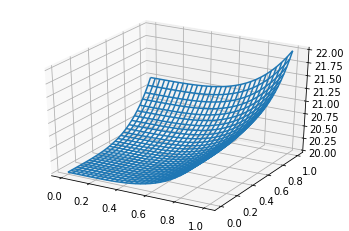

In [27]:
samples = 30
x = np.linspace(0,1,samples)
y = x
X,Y = np.meshgrid(x,y)
Z = Y**4 + X**4+ 20

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X,Y,Z)
#ax.scatter3D(X, Y, Z)

In [28]:
matrix = np.empty((samples*samples,3))
matrix[:,0] = X.reshape(samples*samples)
matrix[:,1] = Y.reshape(samples*samples)
matrix[:,2] = Z.reshape(samples*samples)
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

Reconstruction MSE :  0.0025166751364701736


0.0025166751364701736

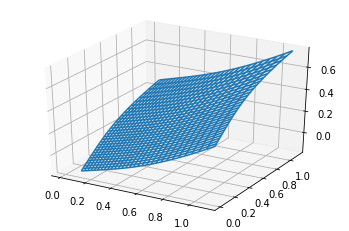

In [29]:
testPCAFit(matrix,2,True)

Reconstruction MSE :  0.0006201412089173078


0.0006201412089173078

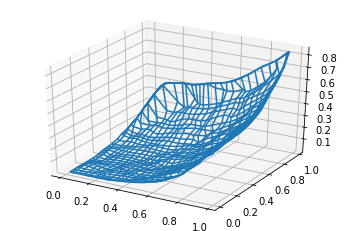

In [30]:
encoding_dim = [100,30,2]
learning_rate=0.0001
batch_size = 100
num_epochs = 1000
testAutoEncoderFit(matrix,encoding_dim,True)

In [31]:
# Random Data

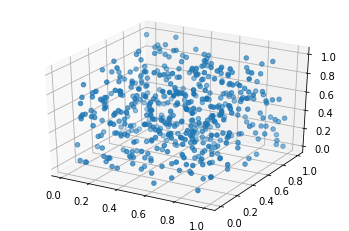

In [32]:
samples = 500
matrix = np.random.uniform(low=0,high=1,size=(samples,3))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(matrix[:,0],matrix[:,1],matrix[:,2])

Reconstruction MSE :  0.025648999283257857


0.025648999283257857

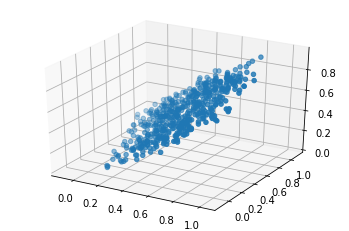

In [33]:
testPCAFit(matrix,2,True,scatter=True)

Reconstruction MSE :  0.012226937092494321


0.012226937092494321

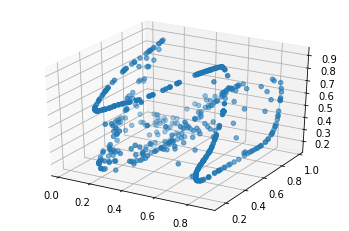

In [34]:
encoding_dim = [100,30,2]
learning_rate=0.001
batch_size = 100
num_epochs = 100
testAutoEncoderFit(matrix,encoding_dim,True,scatter=True)